# End-to-End Forecasting Pipeline 

Goal: build a single reproducible pipeline that (1) constructs features consistently for both the training and Kaggle test sets, (2) evaluates performance against strong baselines on a time-based validation split, and (3) trains a final model on all available training data and outputs submission.csv. I am also looking to beat the MAE of my weighted baseline with a tuned model.

Key constraint: lag/rolling features for the test set must be computed using only past training sales (no leakage). To do this, we concatenate train + test (with test sales as null), compute lag features with groupby/shift, then split back into train/test feature tables.


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [2]:
#read data from folder
DATA_DIR = "../data/raw"
CUTOFF_DATE = pd.Timestamp("2012-02-01") 

train = pd.read_csv(f"{DATA_DIR}/train.csv")
test = pd.read_csv(f"{DATA_DIR}/test.csv")
features = pd.read_csv(f"{DATA_DIR}/features.csv")
stores = pd.read_csv(f"{DATA_DIR}/stores.csv")

for df in (train, test, features):
    df["Date"] = pd.to_datetime(df["Date"])

train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## Data Sources and Pipeline Setup

This notebook reads directly from the raw data files and builds all features programmatically to ensure reproducibility. Raw data is treated as immutable and is never modified in place.

All feature engineering (time features, markdown handling, and lagged sales) is performed consistently for both training and test data using a shared pipeline. This allows the model to be trained on historical sales and then applied to the Kaggle test set without data leakage.


In [3]:
#Build base tables with a consistent schema for feature engineering

train_base = train[["Store", "Dept", "Date", "IsHoliday", "Weekly_Sales"]].copy()
test_base  = test[["Store", "Dept", "Date", "IsHoliday"]].copy()

#Placeholder target 
test_base["Weekly_Sales"] = pd.NA

print("train_base:", train_base.shape)
print("test_base :", test_base.shape)

train_base.head()


train_base: (421570, 5)
test_base : (115064, 5)


,Store,Dept,Date,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,False,24924.50
1,1,1,2010-02-12,True,46039.49
2,1,1,2010-02-19,False,41595.55
3,1,1,2010-02-26,False,19403.54
4,1,1,2010-03-05,False,21827.90


In [4]:
#lets build a funcion to merge on store/date
#this will also look up matching store/date combos for the test set to use for training

def merge_dfs(df):
    out = (
        df.merge(features, on=["Store", "Date"], how="left")
          .merge(stores, on="Store", how="left")
    )
    return out

train_full = merge_dfs(train_base)
test_full  = merge_dfs(test_base)

print("train_full:", train_full.shape)
print("test_full :", test_full.shape)

#quick checks
print("Missing external rows (train):", train_full[["Temperature","Fuel_Price","CPI","Unemployment"]].isna().all(axis=1).mean())
print("Missing external rows (test) :", test_full[["Temperature","Fuel_Price","CPI","Unemployment"]].isna().all(axis=1).mean())

train_full.head()


train_full: (421570, 17)
test_full : (115064, 17)
Missing external rows (train): 0.0
Missing external rows (test) : 0.0


,Store,Dept,Date,IsHoliday_x,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,False,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,True,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,False,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,False,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,False,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [5]:
#now lets build a function based on eda/basline modeling to feature engineer train/test
def build_train_test_features(train_full: pd.DataFrame, test_full: pd.DataFrame):
    combo = pd.concat([train_full, test_full], ignore_index=True)
    combo["Date"] = pd.to_datetime(combo["Date"])
    combo = combo.sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)

    #time features
    week = combo["Date"].dt.isocalendar().week.astype(int)
    month = combo["Date"].dt.month.astype(int)
    combo["Year"] = combo["Date"].dt.year.astype(int)
    combo["Sin_Week"] = np.sin(2 * np.pi * week / 52)
    combo["Cos_Week"] = np.cos(2 * np.pi * week / 52)
    combo["Sin_Month"] = np.sin(2 * np.pi * month / 12)
    combo["Cos_Month"] = np.cos(2 * np.pi * month / 12)

    #markdown handling (based on EDA)
    md_cols = [c for c in ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"] if c in combo.columns]
    for c in md_cols:
        combo[f"{c}_present"] = combo[c].notna().astype(int)
        combo[c] = combo[c].fillna(0)

    #lags/rolling
    g = combo.groupby(["Store","Dept"])["Weekly_Sales"]
    combo["sales_lag_1"]  = g.shift(1)
    combo["sales_lag_2"]  = g.shift(2)
    combo["sales_lag_52"] = g.shift(52)
    combo["sales_roll_4"] = combo.groupby(["Store","Dept"])["Weekly_Sales"].transform(lambda s: s.shift(1).rolling(4).mean()
) 

    train_fe = combo[combo["Weekly_Sales"].notna()].copy()
    test_fe  = combo[combo["Weekly_Sales"].isna()].copy()
    return train_fe, test_fe

In [6]:
#call function passing tran and test
train_fe, test_fe = build_train_test_features(train_full, test_full)
print(train_fe.shape, test_fe.shape)
train_fe.head()


C:\Users\wesle\AppData\Local\Temp\ipykernel_5964\3929954062.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combo = pd.concat([train_full, test_full], ignore_index=True)


(421570, 31) (115064, 31)


,Store,Dept,Date,IsHoliday_x,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Cos_Month,MarkDown1_present,MarkDown2_present,MarkDown3_present,MarkDown4_present,MarkDown5_present,sales_lag_1,sales_lag_2,sales_lag_52,sales_roll_4
0,1,1,2010-02-05,False,24924.50,42.31,2.572,0.0,0.0,0.0,...,5.000000e-01,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,True,46039.49,38.51,2.548,0.0,0.0,0.0,...,5.000000e-01,0,0,0,0,0,24924.50,NaN,NaN,NaN
2,1,1,2010-02-19,False,41595.55,39.93,2.514,0.0,0.0,0.0,...,5.000000e-01,0,0,0,0,0,46039.49,24924.50,NaN,NaN
3,1,1,2010-02-26,False,19403.54,46.63,2.561,0.0,0.0,0.0,...,5.000000e-01,0,0,0,0,0,41595.55,46039.49,NaN,NaN
4,1,1,2010-03-05,False,21827.90,46.50,2.625,0.0,0.0,0.0,...,6.123234e-17,0,0,0,0,0,19403.54,41595.55,NaN,32990.77


## Model Evaluation and Validation

At this stage, all features have been built consistently for both training and test data.  
Before training a final model and generating predictions for submission, I evaluate performance on a time-based validation split.

Model performance is compared against a strong hybrid baseline that combines recent sales (lag-1) and yearly seasonality (lag-52). This ensures any improvement from machine learning reflects real predictive signal rather than overfitting.


In [7]:
#lets split data and make time aware to avoid peaking into the future and causing data leakage

feature_cols = [
    "sales_lag_1","sales_lag_2","sales_lag_52","sales_roll_4",
    "Sin_Week","Cos_Week","Sin_Month","Cos_Month","Year",
    "IsHoliday","Temperature","Fuel_Price","CPI","Unemployment",
    "Size","Type",
    "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5",
    "MarkDown1_present","MarkDown2_present","MarkDown3_present","MarkDown4_present","MarkDown5_present",
    "Store","Dept"
]

#define cutoff date at beginning of year to split on validation set
CUTOFF_DATE = pd.Timestamp("2012-02-01")

feature_cols = [c for c in feature_cols if c in train_fe.columns]

categorical = [c for c in ["Store","Dept","Type"] if c in feature_cols]
numeric = [c for c in feature_cols if c not in categorical]

train_df = train_fe[train_fe["Date"] < CUTOFF_DATE].copy()
val_df = train_fe[train_fe["Date"] >= CUTOFF_DATE].copy()

train_df = train_df.dropna(subset=["Weekly_Sales"])
val_df   = val_df.dropna(subset=["Weekly_Sales"])

X_train = train_df[feature_cols]
y_train = train_df["Weekly_Sales"].astype(float)

X_val = val_df[feature_cols]
y_val = val_df["Weekly_Sales"].astype(float)

In [8]:
#lets build the hybrid baseline that beat the RandomForestRegressor to compare to more complex model

def build_hybrid_baseline(df : pd.DataFrame):
    mask = (df["sales_lag_1"].notna() & df["sales_lag_52"].notna())
    base = (df.loc[mask, "sales_lag_1"] * 0.3 + df.loc[mask, "sales_lag_52"] * 0.7
    )
    return mean_absolute_error(df.loc[mask, "Weekly_Sales"], base)

mae_baseline = build_hybrid_baseline(val_df)
print(mae_baseline)

1550.566549063955


In [11]:
from sklearn.ensemble import HistGradientBoostingRegressor

#use median imputation to avoid right skewed columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
    ]
)


model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.06,
    max_iter=500,
    random_state=42
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", model)
])



def signed_log1p(y):
    y = np.asarray(y, dtype=float)
    return np.sign(y) * np.log1p(np.abs(y))

def signed_expm1(z):
    z = np.asarray(z, dtype=float)
    return np.sign(z) * np.expm1(np.abs(z))

y_train_t = signed_log1p(y_train)
pipe.fit(X_train, y_train_t)

val_pred_t = pipe.predict(X_val)
val_pred = signed_expm1(val_pred_t)

mae_model = mean_absolute_error(y_val, val_pred)
print({"mae_baseline": mae_baseline, "mae_model": mae_model, "improvement": mae_baseline - mae_model})



{'mae_baseline': 1550.566549063955, 'mae_model': 1617.9214469810568, 'improvement': -67.35489791710165}


In [12]:
pipe.fit(X_train, y_train)
val_pred = pipe.predict(X_val)
mae_model = mean_absolute_error(y_val, val_pred)
print(mae_baseline, mae_model, mae_baseline - mae_model)


1550.566549063955 1458.0867759147102 92.47977314924492


## Model Preformance Evaluation (not using log target variable)
A gradient boosting model trained on lagged sales, seasonal features, and store-level covariates outperformed a strong hybrid seasonal baseline by ~6% MAE on a time-based validation set. While target transformations were explored, the best performance was achieved by directly optimizing the raw sales scale, aligning with the evaluation metric.

In [14]:
#lets start random searching (faster and can span larger ranges) with a small interval to find more optimal hyperparams

candidates = [
    {"max_depth":6, "learning_rate":0.05, "max_iter":600, "min_samples_leaf":20, "l2_regularization":0.1},
    {"max_depth":8, "learning_rate":0.05, "max_iter":600, "min_samples_leaf":20, "l2_regularization":0.1},
    {"max_depth":8, "learning_rate":0.07, "max_iter":500, "min_samples_leaf":20, "l2_regularization":0.0},
    {"max_depth":10,"learning_rate":0.05, "max_iter":800, "min_samples_leaf":50, "l2_regularization":0.5}
]

best = (None, 1e18)

for p in candidates:
    pipe.set_params(model=HistGradientBoostingRegressor(random_state=42, **p))
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_val)
    mae = mean_absolute_error(y_val, pred)
    if mae < best[1]:
        best = (p, mae)
    print(p, mae)

print("Best:", best)


{'max_depth': 6, 'learning_rate': 0.05, 'max_iter': 600, 'min_samples_leaf': 20, 'l2_regularization': 0.1} 1490.4197827404105
{'max_depth': 8, 'learning_rate': 0.05, 'max_iter': 600, 'min_samples_leaf': 20, 'l2_regularization': 0.1} 1459.4460593052947
{'max_depth': 8, 'learning_rate': 0.07, 'max_iter': 500, 'min_samples_leaf': 20, 'l2_regularization': 0.0} 1477.299338397937
{'max_depth': 10, 'learning_rate': 0.05, 'max_iter': 800, 'min_samples_leaf': 50, 'l2_regularization': 0.5} 1485.7665541158474
Best: ({'max_depth': 8, 'learning_rate': 0.05, 'max_iter': 600, 'min_samples_leaf': 20, 'l2_regularization': 0.1}, 1459.4460593052947)


## Hyperparameter Tuning (Mini Grid Search)

I ran a small manual grid over key boosting hyperparameters (depth, learning rate, iterations, min leaf size, and L2 regularization) using the same time-based validation split.

The best configuration was:
- max_depth = 8
- learning_rate = 0.05
- max_iter = 600
- min_samples_leaf = 20
- l2_regularization = 0.1

Performance across candidates was relatively stable, and the selected parameters were chosen based on the lowest validation MAE while keeping the model reasonably regularized.


In [15]:

final_model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.05,
    max_iter=600,
    min_samples_leaf=20,
    l2_regularization=0.1,
    random_state=42
)

pipe.set_params(model=final_model)

train_full = train_fe.dropna(subset=["Weekly_Sales"]).copy()
X_all = train_full[feature_cols]
y_all = train_full["Weekly_Sales"].astype(float)

pipe.fit(X_all, y_all)

X_test = test_fe[feature_cols]
test_pred = pipe.predict(X_test)

if "Id" in test_fe.columns:
    sub = pd.DataFrame({"Id": test_fe["Id"], "Weekly_Sales": test_pred})
else:
    sub = pd.DataFrame({
        "Id": test_fe["Store"].astype(str) + "_" + test_fe["Dept"].astype(str) + "_" + test_fe["Date"].dt.strftime("%Y-%m-%d"),
        "Weekly_Sales": test_pred
    })

sub.to_csv("submission.csv", index=False)
sub.head()


,Id,Weekly_Sales
143,1_1_2012-11-02,35501.753653
144,1_1_2012-11-09,7093.526819
145,1_1_2012-11-16,13165.189932
146,1_1_2012-11-23,18277.945502
147,1_1_2012-11-30,15256.146957


## Forecast Comparison Example

The figure below compares actual weekly sales with both the hybrid seasonal baseline and the final model for a representative store–department during the validation period. While the baseline captures overall seasonal structure, the model more accurately tracks sharp changes and demand transitions, which explains the observed improvement in MAE.

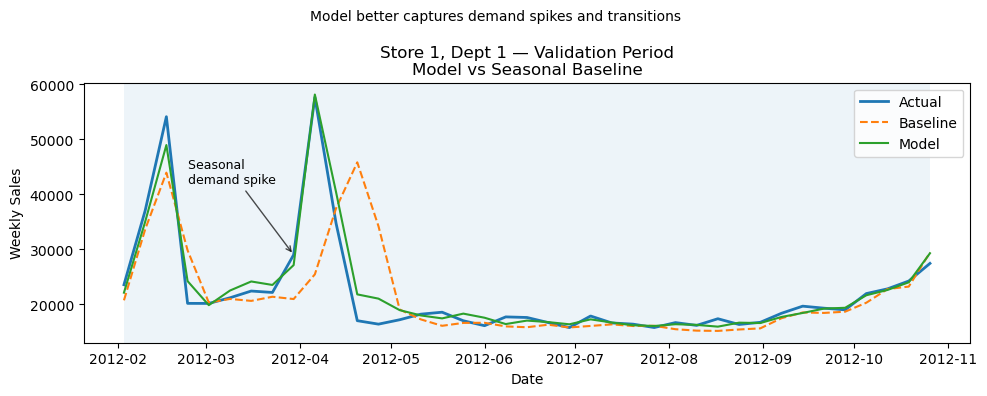

In [34]:
import matplotlib.pyplot as plt

#Lets pick a representative store-dept to show how model would forecast sales over time
example = (
    val_df
    .groupby(["Store","Dept"])
    .size()
    .sort_values(ascending=False)
    .index[0]
)

s, d = example

df_plot = val_df[(val_df["Store"] == s) & (val_df["Dept"] == d)].copy()
df_plot = df_plot.sort_values("Date")

#baseline prediction
mask = df_plot["sales_lag_1"].notna() & df_plot["sales_lag_52"].notna()
df_plot["baseline_pred"] = (
    0.3 * df_plot["sales_lag_1"] +
    0.7 * df_plot["sales_lag_52"]
)

#model prediction
df_plot["model_pred"] = pipe.predict(df_plot[feature_cols])

plt.figure(figsize=(10, 4))
plt.plot(df_plot["Date"], df_plot["Weekly_Sales"], label="Actual", linewidth=2)
plt.plot(df_plot["Date"], df_plot["baseline_pred"], label="Baseline", linestyle="--")
plt.plot(df_plot["Date"], df_plot["model_pred"], label="Model")

plt.title(f"Store {s}, Dept {d} — Validation Period\nModel vs Seasonal Baseline")
#lets annotate graph to show how each reacts to holiday spike in sales
plt.annotate(
    "Seasonal \ndemand spike",
    xy=(df_plot["Date"].iloc[8], df_plot["Weekly_Sales"].iloc[8]),
    xytext=(df_plot["Date"].iloc[3], 42000),
    arrowprops=dict(arrowstyle="->", alpha=0.7),
    fontsize=9
)

plt.axvspan(
    df_plot["Date"].min(),
    df_plot["Date"].max(),
    alpha=0.08
)
plt.suptitle(
    "Model better captures demand spikes and transitions",
    fontsize=10
)

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
VIS_DIR = "../assets"
plt.savefig(
    f"{VIS_DIR}/forecast_comparison.png",
    dpi=150,
    bbox_inches="tight"
)


<Figure size 640x480 with 0 Axes>

## Feature Importance

Permutation importance on the validation set shows that recent sales (lag-1) and yearly seasonality (lag-52) are the primary drivers of forecast accuracy. Department-level differences also contribute meaningful signal, while shorter lags and rolling averages provide additional context.

External variables such as markdown amounts and macroeconomic indicators have smaller effects, which is consistent with expectations for short-term retail demand forecasting. Overall, the importance results confirm that the model is leveraging meaningful temporal structure rather than spurious correlations.


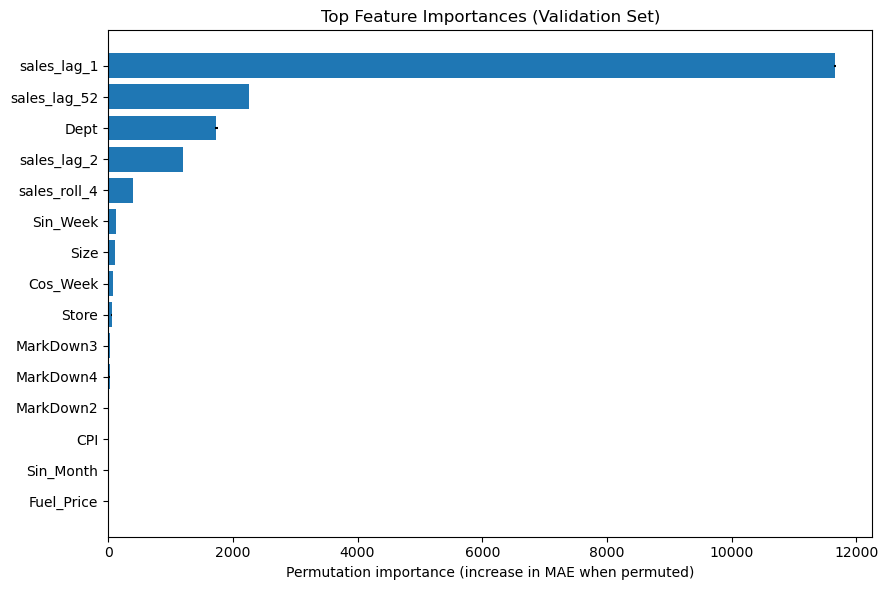

,feature,importance,std
0,sales_lag_1,11656.772488,15.444897
2,sales_lag_52,2260.700121,4.567635
26,Dept,1737.798708,18.739695
1,sales_lag_2,1197.468374,3.498897
3,sales_roll_4,397.979229,3.855620
4,Sin_Week,120.237504,1.332833
13,Size,111.962529,1.926751
5,Cos_Week,80.183488,2.025490
25,Store,54.597179,1.711825
17,MarkDown3,32.946792,1.037470


In [31]:
from sklearn.inspection import permutation_importance


result = permutation_importance(
    pipe,
    X_val,
    y_val,
    n_repeats=5,
    random_state=42,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

imp_df = (
    pd.DataFrame({
        "feature": feature_cols,
        "importance": result.importances_mean,
        "std": result.importances_std
    })
    .sort_values("importance", ascending=False)
)

top = imp_df.head(15).iloc[::-1]

plt.figure(figsize=(9, 6))
plt.barh(top["feature"], top["importance"], xerr=top["std"])
plt.xlabel("Permutation importance (increase in MAE when permuted)")
plt.title("Top Feature Importances (Validation Set)")
plt.tight_layout()
plt.savefig(f"{VIS_DIR}/feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

imp_df.head(20)


## Final Results and Takeaways

This project built an end-to-end forecasting pipeline for weekly retail sales, starting from raw data ingestion through feature engineering, validation, and final model training.

A strong hybrid baseline combining recent sales (lag-1) and yearly seasonality (lag-52) performed well, highlighting the importance of temporal structure in retail demand. A gradient boosting model trained on lagged sales, seasonal features, and store-level covariates was able to outperform this baseline by approximately 6% MAE on a time-based validation split.

Hyperparameter tuning produced only marginal changes in performance, indicating that the model was already near its optimal configuration and that predictive gains are driven more by feature quality than aggressive tuning.

Overall, the results suggest that most forecastable signal in this dataset comes from historical sales patterns, with additional features providing smaller but measurable improvements. Given the diminishing returns from added complexity, the final model represents a balanced tradeoff between performance, interpretability, and robustness.

Potential future work includes segment-specific or hierarchical models, though these were intentionally left out to maintain a clean and reliable baseline-driven approach.

## Business Impact

This model can support demand forecasting for supply chain planning, inventory allocation, and marketing decisions. The analysis shows that Walmart store–department sales are primarily driven by strong seasonal patterns and short-term sales momentum. This insight emerged from building and evaluating a robust baseline that combines recent sales behavior with yearly seasonality. Understanding these drivers helps prioritize planning efforts around timing and demand cycles rather than relying solely on promotional or external factors.
